
# Time Data Analysis — Descriptives & Visualizations (Patched)
This notebook loads **`/content/Time Data (Revision Frequency).xlsx`**, cleans & reshapes the data, computes descriptives, and generates the complete set of visualizations for **Section 2**.  
**Charts use matplotlib only (no seaborn).** CSV summaries are saved to the working directory.


In [ ]:

# 0) Setup
# If needed in Colab, you can install openpyxl:
# !pip -q install openpyxl

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Matplotlib defaults (no custom colors/styles)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
np.random.seed(42)  # for reproducible jitter

print("Environment ready.")


Environment ready.


In [ ]:

# 1) Load the Excel file from a fixed path (no upload dialog)
# Reads: /content/Time Data (Revision Frequency).xlsx
path = Path('/content/Time Data (Revision Frequency).xlsx')
if not path.exists():
    raise FileNotFoundError(f"File not found at: {path}")

multi_ok = True
try:
    df = pd.read_excel(path, header=[0, 1], engine="openpyxl")
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("Not a true MultiIndex header; falling back to single header.")
except Exception:
    multi_ok = False
    df = pd.read_excel(path, header=0, engine="openpyxl")

def flatten_cols(cols):
    if isinstance(cols, pd.MultiIndex):
        flat = []
        for tup in cols:
            parts = [str(x) for x in tup if (isinstance(x, str) and x.strip())
                     or (isinstance(x, (int, float)) and not pd.isna(x))]
            flat.append(" | ".join(p.strip() for p in parts))
        return flat
    return [str(c) for c in cols]

df.columns = flatten_cols(df.columns)
orig_cols = df.columns.copy()

print("Loaded:", path.name)
print(f"Multi-row header detected: {multi_ok}")
print(f"{len(df)} rows, {len(df.columns)} columns")


Loaded: Time Data (Revision Frequency).xlsx
Multi-row header detected: True
34 rows, 19 columns


In [ ]:

# 2) Basic cleaning (ID column, drop demo/test rows)
def find_col(patterns):
    for pat in patterns:
        hits = [c for c in df.columns if re.search(pat, c, flags=re.I)]
        if hits:
            return hits[0]
    return None

first_col = find_col([r"\bfirst\s*name\b", r"\bfname\b"])
last_col  = find_col([r"\blast\s*name\b", r"\blname\b", r"\bsurname\b"])
pid_col   = find_col([r"\bparticipant[_\s-]*id\b", r"\bpart[\w\s-]*id\b", r"\buser[_\s-]*id\b"])
email_col = find_col([r"\bemail\b"])

if first_col and last_col:
    df["participant_id"] = (df[first_col].astype(str).str.strip() + " " +
                            df[last_col].astype(str).str.strip())
elif pid_col:
    df["participant_id"] = df[pid_col].astype(str).str.strip()
elif email_col:
    df["participant_id"] = df[email_col].astype(str).str.strip()
else:
    df["participant_id"] = [f"P{ix:03d}" for ix in range(1, len(df)+1)]

mask_demo = df["participant_id"].str.lower().eq("demo demo")
n_demo = int(mask_demo.sum())
df = df.loc[~mask_demo].copy()
if n_demo:
    print(f"Dropped {n_demo} 'Demo Demo' row(s).")

print("ID preview:", df["participant_id"].head(5).tolist())


Dropped 1 'Demo Demo' row(s).
ID preview: ['Sworna Roy', 'Md. Arifur Rahman', 'Md Abubakkar Shiddique Shovo', 'Mamun Mia', 'Yogindra Hereshbhai Mehta']


In [ ]:
# 3) Robust detection for TIME and REVISION columns (handles more naming styles)

import re

strategy_map = {"T1":"Template","T2":"Example","T3":"Feedback","T4":"Control"}
strategy_order = ["Template", "Example", "Feedback", "Control"]

domain_patterns = {
    "Creative Writing": r"(creative|writing|cw)",
    "Data Analysis": r"(data\s*analysis|analysis|da)",
    "Educational Content": r"(educational|education|content|ecg|edu)",
}
domain_order = ["Creative Writing", "Data Analysis", "Educational Content"]

# ---- helpers
def norm(s: str) -> str:
    s = re.sub(r"[_\-\|\t]+", " ", str(s))
    s = re.sub(r"\s+", " ", s)
    return s.strip().lower()

lc = {c: norm(c) for c in df.columns}  # lowercase/normalized header map

TIME_TOKENS = r"(time|minutes|min|duration|spent)"
REV_TOKENS  = r"(number\s*of\s*prompt|prompting|revisio|revisions?)"

strategy_aliases = {
    "Template": [r"\bt1\b", r"\btemplate\b", r"\btemp\b"],
    "Example":  [r"\bt2\b", r"\bexample\b", r"\bex\b"],
    "Feedback": [r"\bt3\b", r"\bfeedback\b"],
    "Control":  [r"\bt4\b", r"\bcontrol\b"],
}

# ---------- TIME COLUMNS
# Candidate "time-like" columns
time_like = [c for c in df.columns if re.search(TIME_TOKENS, lc[c])]

time_cols = {}

# Pass 1: time_like + strategy alias in the same header
for strat in strategy_order:
    aliases = strategy_aliases[strat]
    cands = [c for c in time_like if any(re.search(pat, lc[c]) for pat in aliases)]
    if len(cands) == 1:
        time_cols[strat] = cands[0]
    elif len(cands) > 1:
        # Prefer ones that also include an explicit T#
        prefer = [c for c in cands if re.search(r"\bt[1234]\b", lc[c])]
        time_cols[strat] = (prefer[0] if prefer else sorted(cands, key=lambda x: len(lc[x]))[0])

# Pass 2: if still missing, allow matching by T# only
for tcode, strat in strategy_map.items():
    if strat not in time_cols:
        cands = [c for c in time_like if re.search(fr"\b{tcode.lower()}\b", lc[c])]
        if cands:
            time_cols[strat] = sorted(cands, key=lambda x: len(lc[x]))[0]

# Pass 3: if still missing, search near revision anchors for that T#
if len(time_cols) < 4:
    # Find revision anchors like "Number of prompting for T# ..."
    anchors = [c for c in df.columns if re.search(REV_TOKENS, lc[c])]
    for tcode, strat in strategy_map.items():
        if strat in time_cols:
            continue
        # anchors that mention this T#
        t_anchors = [a for a in anchors if re.search(fr"\b{tcode.lower()}\b", lc[a])]
        if not t_anchors:
            # anchors that mention this strategy name
            t_anchors = [a for a in anchors if any(re.search(p, lc[a]) for p in strategy_aliases[strat])]
        # look ±6 columns around anchor for a time_like column
        for a in t_anchors:
            idx = list(df.columns).index(a)
            neighbor_idx = list(range(max(0, idx-6), min(len(df.columns), idx+7)))
            neighbor_cols = [list(df.columns)[i] for i in neighbor_idx]
            cands = [c for c in neighbor_cols if c in time_like]
            if cands:
                # choose the shortest header as likely the specific one
                time_cols[strat] = sorted(cands, key=lambda x: len(lc[x]))[0]
                break

# ---------- REVISION COLUMNS (strategy × domain)
rev_cols = {}
# Pass 1: direct match of T# + revision token + domain pattern
for tcode, strat in strategy_map.items():
    for domain, dpat in domain_patterns.items():
        cands = [c for c in df.columns
                 if re.search(fr"\b{tcode.lower()}\b", lc[c])
                 and re.search(REV_TOKENS, lc[c])
                 and re.search(dpat, lc[c])]
        if cands:
            rev_cols[(strat, domain)] = cands[0]

# Pass 2: if some domain missing, try aliases (“template”, etc.)
for strat in strategy_order:
    for domain, dpat in domain_patterns.items():
        if (strat, domain) in rev_cols:
            continue
        cands = [c for c in df.columns
                 if any(re.search(p, lc[c]) for p in strategy_aliases[strat])
                 and re.search(REV_TOKENS, lc[c])
                 and re.search(dpat, lc[c])]
        if cands:
            rev_cols[(strat, domain)] = cands[0]

# Pass 3: fallback — assume 3 columns after an anchor belong to the 3 domains in fixed order
for tcode, strat in strategy_map.items():
    missing = [(strat, d) for d in domain_order if (strat, d) not in rev_cols]
    if not missing:
        continue
    anchors = [c for c in df.columns
               if re.search(REV_TOKENS, lc[c]) and
                  (re.search(fr"\b{tcode.lower()}\b", lc[c]) or any(re.search(p, lc[c]) for p in strategy_aliases[strat]))]
    if anchors:
        a = anchors[0]
        idx = list(df.columns).index(a)
        follow = list(df.columns)[idx: idx+4]  # anchor + next 3 cols
        for i, d in enumerate(domain_order, start=1):
            if i < len(follow):
                rev_cols.setdefault((strat, d), follow[i])

# ---------- Diagnostics (no hard fail)
print("\nTime columns detected:")
for s in strategy_order:
    print(f"  {s}: {time_cols.get(s, '❌ NOT FOUND')}")

print("\nRevision columns detected (strategy, domain -> column):")
for s in strategy_order:
    for d in domain_order:
        print(f"  ({s}, {d}): {rev_cols.get((s,d), '❌ NOT FOUND')}")

# Soft warnings if something is still missing (but continue running)
missing_time = [s for s in strategy_order if s not in time_cols]
missing_rev  = [(s,d) for s in strategy_order for d in domain_order if (s,d) not in rev_cols]

if missing_time:
    print("\n⚠️ WARNING: Could not auto-detect time columns for:", missing_time)
    print("   Time-like headers I can see:")
    for c in time_like:
        print("    •", c)

if missing_rev:
    print("\n⚠️ WARNING: Could not auto-detect some revision columns:", missing_rev)
    print("   Revision-like headers I can see:")
    rev_like = [c for c in df.columns if re.search(REV_TOKENS, lc[c])]
    for c in rev_like:
        print("    •", c)

# OPTIONAL: manual override (uncomment and fill exact header names if needed)
# time_cols.update({
#     "Template": "Time for T1",
#     "Example":  "Time for T2",
#     "Feedback": "Time for T3",
#     "Control":  "Time for T4",
# })



Time columns detected:
  Template: Time for Template Based | Unnamed: 2_level_1
  Example: Time for Example Based | Unnamed: 3_level_1
  Feedback: Time for Feedback Based | Unnamed: 4_level_1
  Control: Time for Control Based | Unnamed: 5_level_1

Revision columns detected (strategy, domain -> column):
  (Template, Creative Writing): Number of prompting for T1 | Creative Writing
  (Template, Data Analysis): Number of prompting for T1 | Data Analysis
  (Template, Educational Content): Number of prompting for T1 | Educational Content Generation
  (Example, Creative Writing): Number of prompting for T2 | Creative Writing
  (Example, Data Analysis): Number of prompting for T2 | Data Analysis
  (Example, Educational Content): Number of prompting for T2 | Educational Content Generation
  (Feedback, Creative Writing): Number of prompting for T3 | Creative Writing
  (Feedback, Data Analysis): Number of prompting for T3 | Data Analysis
  (Feedback, Educational Content): Number of prompting for

In [ ]:

# 4) Build tidy long tables: revisions_long and time_long
rows = []
for _, r in df.iterrows():
    pid = r["participant_id"]
    for strat in strategy_order:
        for domain in domain_order:
            col = rev_cols[(strat, domain)]
            val = pd.to_numeric(r.get(col, np.nan), errors="coerce")
            rows.append({
                "participant_id": pid,
                "strategy": strat,
                "domain": domain,
                "revisions": val
            })
revisions_long = pd.DataFrame(rows)

rows_t = []
for _, r in df.iterrows():
    pid = r["participant_id"]
    for strat in strategy_order:
        col = time_cols[strat]
        t = pd.to_numeric(r.get(col, np.nan), errors="coerce")
        rows_t.append({
                "participant_id": pid,
                "strategy": strat,
                "time_minutes": t
        })
time_long = pd.DataFrame(rows_t)

revisions_long["revisions"] = revisions_long["revisions"].clip(lower=0)
time_long["time_minutes"] = time_long["time_minutes"].clip(lower=0)

print(revisions_long.head(6))
print(time_long.head(6))


  participant_id  strategy               domain  revisions
0     Sworna Roy  Template     Creative Writing        1.0
1     Sworna Roy  Template        Data Analysis        1.0
2     Sworna Roy  Template  Educational Content        1.0
3     Sworna Roy   Example     Creative Writing        1.0
4     Sworna Roy   Example        Data Analysis        1.0
5     Sworna Roy   Example  Educational Content        1.0
      participant_id  strategy  time_minutes
0         Sworna Roy  Template          6.55
1         Sworna Roy   Example         17.03
2         Sworna Roy  Feedback         13.68
3         Sworna Roy   Control         11.42
4  Md. Arifur Rahman  Template         15.73
5  Md. Arifur Rahman   Example         10.87


In [ ]:

# 5) Compute strategy-level totals & rates
totals = (revisions_long
          .groupby(["participant_id", "strategy"], as_index=False)["revisions"]
          .sum()
          .rename(columns={"revisions": "revs_total_strategy"}))

strategy_df = totals.merge(time_long, on=["participant_id", "strategy"], how="left")

def safe_rate(total, minutes):
    if pd.isna(minutes) or minutes <= 0:
        return np.nan
    return total / minutes

strategy_df["rev_rate"] = [safe_rate(t, m) for t, m in zip(strategy_df["revs_total_strategy"],
                                                          strategy_df["time_minutes"])]
strategy_df["strategy"] = pd.Categorical(strategy_df["strategy"],
                                         categories=["Template", "Example", "Feedback", "Control"],
                                         ordered=True)

strategy_df.head()


,participant_id,strategy,revs_total_strategy,time_minutes,rev_rate
0,Abu Sayeed Bin Mozahid,Control,13.0,15.60,0.833333
1,Abu Sayeed Bin Mozahid,Example,3.0,12.77,0.234926
2,Abu Sayeed Bin Mozahid,Feedback,8.0,10.80,0.740741
3,Abu Sayeed Bin Mozahid,Template,3.0,16.32,0.183824
4,Alfat Jahan Rony,Control,3.0,9.20,0.326087


In [ ]:
# 6) Descriptives (single helper, no duplicates) + CSV exports
def describe_series(s: pd.Series):
    s = s.dropna().astype(float)
    if len(s) == 0:
        return pd.Series({
            "n": 0, "mean": np.nan, "std": np.nan, "min": np.nan,
            "25%": np.nan, "50% (median)": np.nan, "75%": np.nan, "max": np.nan, "IQR": np.nan
        })
    q = s.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    return pd.Series({
        "n": int(s.count()),
        "mean": s.mean(),
        "std": s.std(ddof=1),
        "min": q.loc[0.0],
        "25%": q.loc[0.25],
        "50% (median)": q.loc[0.5],
        "75%": q.loc[0.75],
        "max": q.loc[1.0],
        "IQR": q.loc[0.75] - q.loc[0.25],
    })

# Make stats columns (not a MultiIndex Series)
desc_revs = (strategy_df.groupby("strategy")["revs_total_strategy"]
             .apply(describe_series).unstack().round(3))
desc_time = (strategy_df.groupby("strategy")["time_minutes"]
             .apply(describe_series).unstack().round(3))
desc_rate = (strategy_df.groupby("strategy")["rev_rate"]
             .apply(describe_series).unstack().round(3))

# Add a proper column to each DataFrame
desc_revs["Metric"] = "Revisions"
desc_time["Metric"]  = "Time"
desc_rate["Metric"]  = "Revision Rate"

# Stack them row-wise
desc_combined = (pd.concat([desc_revs, desc_time, desc_rate], axis=0)
                   .reset_index()  # 'strategy' becomes a column
                   .rename(columns={"index": "strategy"})  # harmless if not present
                   [["Metric","strategy","n","mean","std","min","25%","50% (median)","75%","max","IQR"]])

print("\nCombined descriptives:")
print(desc_combined)

# Save CSVs
desc_revs.to_csv("desc_revisions_by_strategy.csv")
desc_time.to_csv("desc_time_by_strategy.csv")
desc_rate.to_csv("desc_rate_by_strategy.csv")
desc_combined.to_csv("desc_combined.csv", index=False)

# Per-domain descriptives and CSV
def describe_df(df_sub, col):
    return (df_sub.groupby(["strategy"])[col]
            .apply(describe_series).unstack().round(3))

desc_by_domain = []
for domain in ["Creative Writing", "Data Analysis", "Educational Content"]:
    sub = revisions_long[revisions_long["domain"] == domain]
    table = describe_df(sub, "revisions").reset_index()
    table.insert(0, "domain", domain)
    desc_by_domain.append(table)

desc_by_domain = pd.concat(desc_by_domain, ignore_index=True)
print("\nDescriptives — Revisions by Strategy × Domain:")
print(desc_by_domain)

desc_by_domain.to_csv("desc_revisions_by_strategy_domain.csv", index=False)
print("\nSaved CSVs: desc_revisions_by_strategy.csv, desc_time_by_strategy.csv, desc_rate_by_strategy.csv, desc_combined.csv, desc_revisions_by_strategy_domain.csv")



Combined descriptives:
           Metric  strategy     n    mean    std    min     25%  50% (median)  \
0       Revisions  Template  33.0   4.121  1.883  3.000   3.000         3.000   
1       Revisions   Example  33.0   3.848  1.004  3.000   3.000         4.000   
2       Revisions  Feedback  33.0   8.182  2.391  6.000   6.000         8.000   
3       Revisions   Control  33.0   4.242  2.031  3.000   3.000         3.000   
4            Time  Template  33.0  13.886  6.703  5.550   8.920        12.600   
5            Time   Example  33.0  13.318  5.637  4.550  10.020        12.570   
6            Time  Feedback  33.0  14.211  7.293  5.750   9.020        13.680   
7            Time   Control  33.0  11.518  5.868  5.580   8.150         9.650   
8   Revision Rate  Template  33.0   0.340  0.179  0.113   0.225         0.318   
9   Revision Rate   Example  33.0   0.332  0.136  0.094   0.230         0.318   
10  Revision Rate  Feedback  33.0   0.733  0.485  0.268   0.386         0.553   
11  

/tmp/ipython-input-1983674735.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_revs = (strategy_df.groupby("strategy")["revs_total_strategy"]
/tmp/ipython-input-1983674735.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_time = (strategy_df.groupby("strategy")["time_minutes"]
/tmp/ipython-input-1983674735.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_rate = (strategy_df.groupby("strategy")["

In [ ]:
# 6) Descriptives (robust) + CSV exports

def describe_series(s: pd.Series):
    s = s.dropna().astype(float)
    if len(s) == 0:
        return pd.Series({
            "n": 0, "mean": np.nan, "std": np.nan, "min": np.nan,
            "25%": np.nan, "50% (median)": np.nan, "75%": np.nan, "max": np.nan, "IQR": np.nan
        })
    q = s.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    return pd.Series({
        "n": int(s.count()),
        "mean": s.mean(),
        "std": s.std(ddof=1),
        "min": q.loc[0.0],
        "25%": q.loc[0.25],
        "50% (median)": q.loc[0.5],
        "75%": q.loc[0.75],
        "max": q.loc[1.0],
        "IQR": q.loc[0.75] - q.loc[0.25],
    })

def desc_table(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
    """Return a DataFrame of descriptives by strategy (never a Series)."""
    out = df_in.groupby("strategy", observed=True)[col].apply(describe_series)
    # Coerce to DataFrame reliably
    if isinstance(out, pd.Series):
        # If it's a multi-index Series (strategy, stat) -> unstack to columns
        if isinstance(out.index, pd.MultiIndex):
            out = out.unstack()
        else:
            out = out.to_frame(name=col)  # fallback (shouldn't usually happen)
    return out.round(3)

# Build three tables as real DataFrames
desc_revs = desc_table(strategy_df, "revs_total_strategy")
desc_time = desc_table(strategy_df, "time_minutes")
desc_rate = desc_table(strategy_df, "rev_rate")

print("Revisions (total) by strategy:\n", desc_revs, "\n")
print("Time (minutes) by strategy:\n", desc_time, "\n")
print("Revision rate (revisions/min) by strategy:\n", desc_rate, "\n")

# --- Combine tables safely ---
pieces = []
for label, tbl in [("Revisions", desc_revs), ("Time", desc_time), ("Revision Rate", desc_rate)]:
    t = tbl.copy()
    t["Metric"] = label
    pieces.append(t)

desc_combined = pd.concat(pieces).reset_index()

# Normalize the strategy column name
if "strategy" not in desc_combined.columns:
    for candidate in ("level_0", "index"):
        if candidate in desc_combined.columns:
            desc_combined = desc_combined.rename(columns={candidate: "strategy"})
            break

# Column ordering (keep only those that exist)
cols = ["Metric","strategy","n","mean","std","min","25%","50% (median)","75%","max","IQR"]
desc_combined = desc_combined[[c for c in cols if c in desc_combined.columns]]

print("\nCombined descriptives:\n", desc_combined)

# Save CSVs
desc_revs.to_csv("desc_revisions_by_strategy.csv")
desc_time.to_csv("desc_time_by_strategy.csv")
desc_rate.to_csv("desc_rate_by_strategy.csv")
desc_combined.to_csv("desc_combined.csv", index=False)

# --- Per-domain descriptives and CSV ---
def describe_df(df_sub, col):
    return df_sub.groupby(["strategy"], observed=True)[col].apply(describe_series)

desc_by_domain = []
for domain in ["Creative Writing", "Data Analysis", "Educational Content"]:
    sub = revisions_long[revisions_long["domain"] == domain]
    tab = describe_df(sub, "revisions")
    # Coerce to DataFrame
    if isinstance(tab, pd.Series):
        if isinstance(tab.index, pd.MultiIndex):
            tab = tab.unstack()
        else:
            tab = tab.to_frame(name="value")
    tab = tab.reset_index()
    tab.insert(0, "domain", domain)
    desc_by_domain.append(tab)

desc_by_domain = pd.concat(desc_by_domain, ignore_index=True)
print("\nDescriptives — Revisions by Strategy × Domain:\n", desc_by_domain)

desc_by_domain.to_csv("desc_revisions_by_strategy_domain.csv", index=False)
print("\nSaved CSVs: desc_revisions_by_strategy.csv, desc_time_by_strategy.csv, desc_rate_by_strategy.csv, desc_combined.csv, desc_revisions_by_strategy_domain.csv")


Revisions (total) by strategy:
              n   mean    std  min  25%  50% (median)  75%   max  IQR
strategy                                                            
Template  33.0  4.121  1.883  3.0  3.0           3.0  5.0  11.0  2.0
Example   33.0  3.848  1.004  3.0  3.0           4.0  4.0   6.0  1.0
Feedback  33.0  8.182  2.391  6.0  6.0           8.0  9.0  15.0  3.0
Control   33.0  4.242  2.031  3.0  3.0           3.0  5.0  13.0  2.0 

Time (minutes) by strategy:
              n    mean    std   min    25%  50% (median)    75%    max   IQR
strategy                                                                    
Template  33.0  13.886  6.703  5.55   8.92         12.60  15.72  39.93  6.80
Example   33.0  13.318  5.637  4.55  10.02         12.57  17.02  32.08  7.00
Feedback  33.0  14.211  7.293  5.75   9.02         13.68  17.93  40.97  8.91
Control   33.0  11.518  5.868  5.58   8.15          9.65  11.42  33.78  3.27 

Revision rate (revisions/min) by strategy:
              n 

/tmp/ipython-input-1407003469.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(strategy_df["strategy"]):


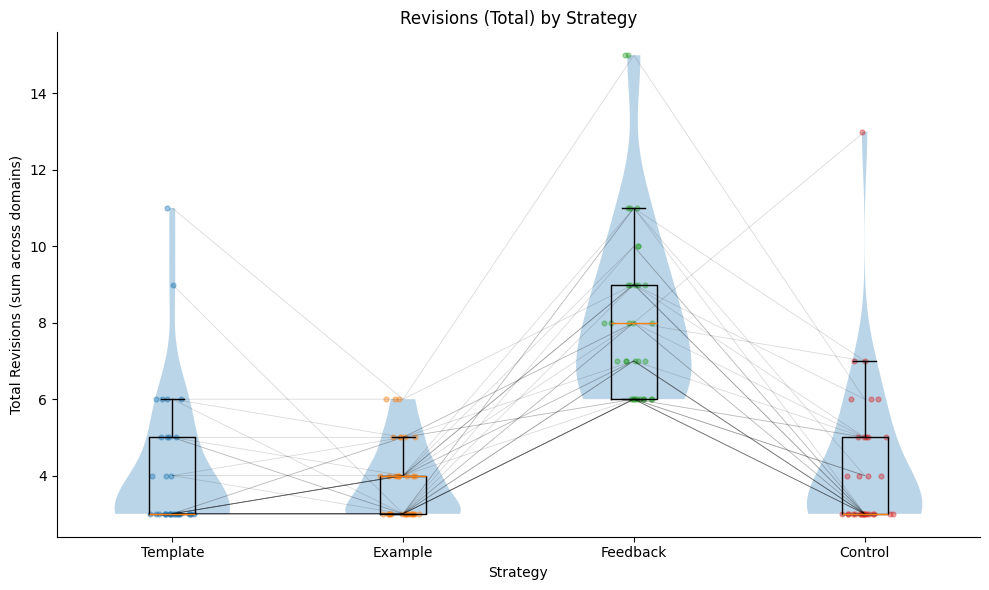

In [ ]:
# 8) Plot — Revisions (Total) by Strategy  [FIXED]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Determine plotting order
if pd.api.types.is_categorical_dtype(strategy_df["strategy"]):
    order = list(strategy_df["strategy"].cat.categories)
else:
    # fallback to canonical order, keeping only those present
    canonical = ["Template", "Example", "Feedback", "Control"]
    present = strategy_df["strategy"].dropna().unique().tolist()
    order = [s for s in canonical if s in present]

# Helpers
def jitter_x(center, n, scale=0.05):
    return np.random.normal(loc=center, scale=scale, size=n)

pos = {s: i for i, s in enumerate(order, start=1)}

# Build y-arrays per strategy
data_by_strat = [
    strategy_df.loc[strategy_df["strategy"] == s, "revs_total_strategy"].dropna().values
    for s in order
]

# Plot
fig, ax = plt.subplots()
ax.violinplot(data_by_strat, showmeans=False, showmedians=False, showextrema=False)
ax.boxplot(
    data_by_strat,
    widths=0.2,
    positions=np.arange(1, len(order) + 1),
    showfliers=False
)
for i, y in enumerate(data_by_strat, start=1):
    if len(y):
        ax.scatter(jitter_x(i, len(y)), y, alpha=0.4, s=12)

# Paired lines per participant (only for strategies present)
for pid, sub in strategy_df.groupby("participant_id"):
    sub = sub[sub["strategy"].isin(order)].copy()
    sub["x"] = sub["strategy"].map(pos)
    sub = sub.dropna(subset=["x"]).sort_values("x")
    if len(sub) >= 2:
        ax.plot(sub["x"].values, sub["revs_total_strategy"].values, lw=0.6, alpha=0.15, color="black")

ax.set_title("Revisions (Total) by Strategy")
ax.set_xlabel("Strategy")
ax.set_ylabel("Total Revisions (sum across domains)")
ax.set_xticks(np.arange(1, len(order) + 1))
ax.set_xticklabels(order)
plt.tight_layout()
plt.show()


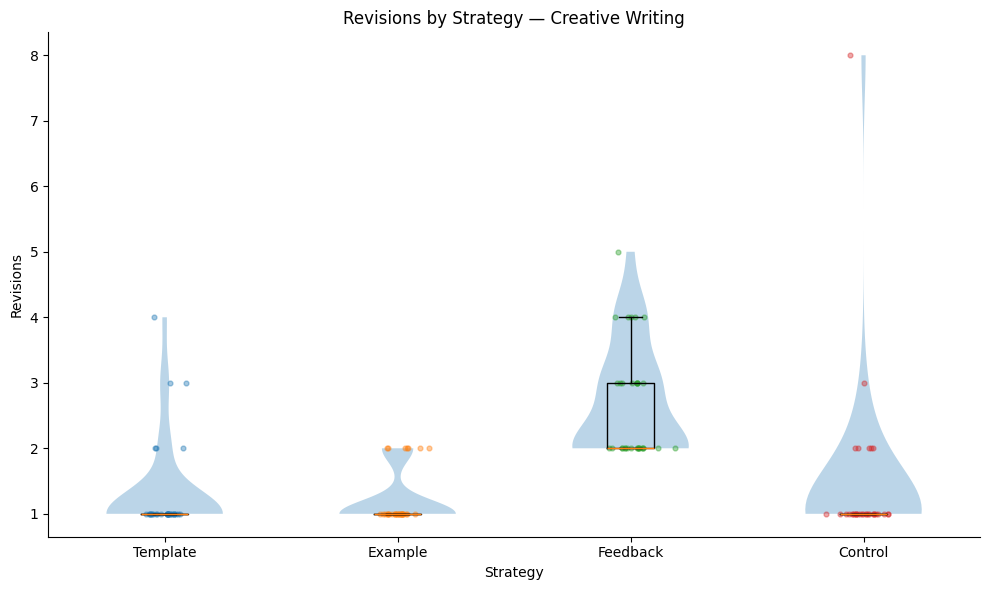

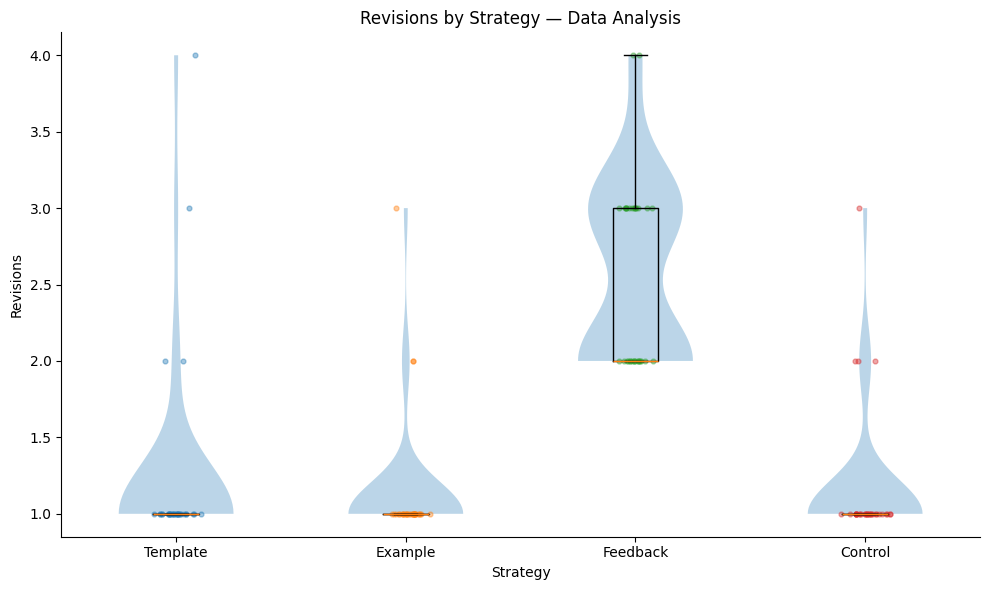

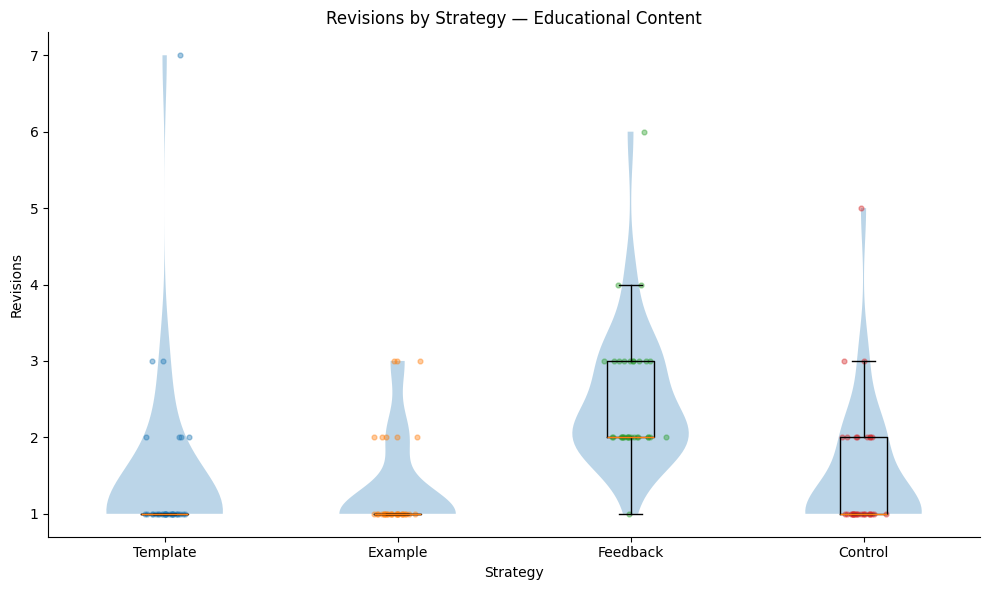

In [ ]:

# 9) Plots — Revisions by Strategy × Domain (three separate figures)
for domain in ["Creative Writing", "Data Analysis", "Educational Content"]:
    fig, ax = plt.subplots()
    subset = revisions_long[revisions_long["domain"] == domain]
    data_by_strat = [subset.loc[subset["strategy"] == s, "revisions"].dropna().values for s in order]

    ax.violinplot(data_by_strat, showmeans=False, showmedians=False, showextrema=False)
    ax.boxplot(data_by_strat, widths=0.2, positions=np.arange(1, len(order)+1), showfliers=False)
    for i, y in enumerate(data_by_strat, start=1):
        if len(y) == 0:
            continue
        ax.scatter(jitter_x(i, len(y)), y, alpha=0.4, s=12)

    ax.set_title(f"Revisions by Strategy — {domain}")
    ax.set_xlabel("Strategy")
    ax.set_ylabel("Revisions")
    ax.set_xticks(np.arange(1, len(order)+1))
    ax.set_xticklabels(order)
    plt.tight_layout()
    # plt.savefig(f"fig_revisions_by_strategy_{domain.lower().replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
    plt.show()


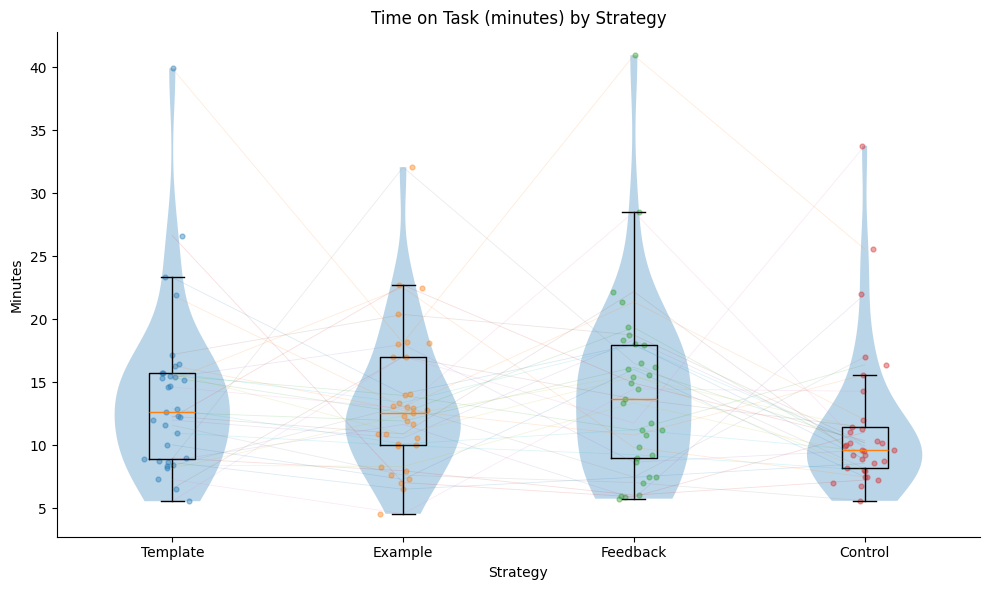

In [ ]:

# 10) Plot — Time on Task (minutes) by Strategy
fig, ax = plt.subplots()
data_by_strat = [strategy_df.loc[strategy_df["strategy"] == s, "time_minutes"].dropna().values for s in order]

ax.violinplot(data_by_strat, showmeans=False, showmedians=False, showextrema=False)
ax.boxplot(data_by_strat, widths=0.2, positions=np.arange(1, len(order)+1), showfliers=False)
for i, y in enumerate(data_by_strat, start=1):
    if len(y) == 0:
        continue
    ax.scatter(jitter_x(i, len(y)), y, alpha=0.4, s=12)

# Paired lines
for pid, sub in strategy_df.groupby("participant_id"):
    sub = sub.sort_values("strategy")
    xs = [pos[s] for s in sub["strategy"]]
    ys = sub["time_minutes"].values
    if len(xs) == 4:
        ax.plot(xs, ys, lw=0.6, alpha=0.15)

ax.set_title("Time on Task (minutes) by Strategy")
ax.set_xlabel("Strategy")
ax.set_ylabel("Minutes")
ax.set_xticks(np.arange(1, len(order)+1))
ax.set_xticklabels(order)
plt.tight_layout()
# plt.savefig("fig_time_by_strategy.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:

# 11) Plot — Revision Rate (revisions/min) by Strategy
fig, ax = plt.subplots()
data_by_strat = [strategy_df.loc[strategy_df["strategy"] == s, "rev_rate"].dropna().values for s in order]

ax.violinplot(data_by_strat, showmeans=False, showmedians=False, showextrema=False)
ax.boxplot(data_by_strat, widths=0.2, positions=np.arange(1, len(order)+1), showfliers=False)
for i, y in enumerate(data_by_strat, start=1):
    if len(y) == 0:
        continue
    ax.scatter(jitter_x(i, len(y)), y, alpha=0.4, s=12)

# Optional paired lines
for pid, sub in strategy_df.groupby("participant_id"):
    sub = sub.sort_values("strategy")
    xs = [pos[s] for s in sub["strategy"]]
    ys = sub["rev_rate"].values
    if len(xs) == 4:
        ax.plot(xs, ys, lw=0.6, alpha=0.15)

ax.set_title("Revision Rate by Strategy")
ax.set_xlabel("Strategy")
ax.set_ylabel("Revisions per Minute")
ax.set_xticks(np.arange(1, len(order)+1))
ax.set_xticklabels(order)
plt.tight_layout()
# plt.savefig("fig_revision_rate_by_strategy.png", dpi=300, bbox_inches="tight")
plt.show()
